In [201]:
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,change_tomorrow
Date,,,,,,,
2020-01-02 00:00:00+00:00,17.808577,20.790001,20.830000,20.650000,20.680000,7194700,-1.266440
2020-01-03 00:00:00+00:00,17.585859,20.530001,20.680000,20.450001,20.480000,5421800,0.388161
2020-01-06 00:00:00+00:00,17.654388,20.610001,20.790001,20.510000,20.660000,9312500,0.242010
2020-01-07 00:00:00+00:00,17.697220,20.660000,20.780001,20.510000,20.559999,6536200,1.290017
2020-01-08 00:00:00+00:00,17.928505,20.930000,20.990000,20.530001,20.530001,7780100,1.459508
...,...,...,...,...,...,...,...
2024-11-20 00:00:00+00:00,36.680000,36.680000,36.980000,36.419998,36.869999,4929000,3.244525
2024-11-21 00:00:00+00:00,37.910000,37.910000,37.959999,36.730000,36.770000,5969400,0.576977
2024-11-22 00:00:00+00:00,38.130001,38.130001,38.650002,37.880001,37.959999,6961100,2.977095


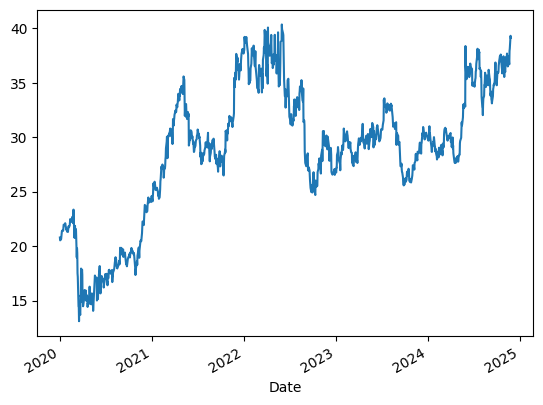

In [263]:
ticker = "hpq"
df = yf.download(ticker)
df = df.loc["2020-01-01":,:]
df = df.droplevel('Ticker', axis=1)
df["change_tomorrow"]=df.Close.pct_change(-1)*(-100)
df = df.dropna()
df.Close.plot()
df

In [264]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [265]:
model_dt = DecisionTreeRegressor(max_depth=25, random_state=42)
model_ab = AdaBoostRegressor()

In [266]:
from backtesting import Backtest, Strategy

In [270]:
class Regression(Strategy):
    print("START")
    limit_buy = 0
    limit_sell = -3
    n_train_factor =3
    n_train = 200
    coef_retrain = 10
    model = None
    
    def init(self):
        self.already_bought = False
        self.model = Regression.model
        
        X_train = self.data.df.iloc[:self.n_train, :-1]
        y_train = self.data.df.iloc[:self.n_train, -1]
        
        self.model.fit(X=X_train, y=y_train)

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :-1]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        # print(f"predict for {explanatory_today.index} ")
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass


class WalkForwardAnchored(Regression):
    def next(self):
        
        # we don't take any action and move on to the following day
        if len(self.data) < (self.n_train*self.n_train_factor):
            return
        
        # we retrain the model each 200 days
        if len(self.data) % self.coef_retrain == 0:
            X_train = self.data.df.iloc[:-1, :-1]
            y_train = self.data.df.iloc[:-1, -1]
            # print(f"Train start {X_train.index[0]}, train end {X_train.index[-1]}")

            self.model.fit(X_train, y_train)

            super().next()
            
        else:
            
            super().next()
            
            
class WalkForwardUnanchored(Regression):
    def next(self):
        
        # we don't take any action and move on to the following day
        if len(self.data) < (self.n_train*self.n_train_factor):
            return
        
        # we retrain the model each 200 days
        if len(self.data) % self.coef_retrain == 0:
            X_train = self.data.df.iloc[-(self.n_train*self.n_train_factor):-1, :-1]
            y_train = self.data.df.iloc[-(self.n_train*self.n_train_factor):-1, -1]
            # print(f"Train start {X_train.index[0]}, train end {X_train.index[-1]}")

            self.model.fit(X_train, y_train)

            super().next()
            
        else:
            
            super().next()

START


In [271]:
Regression.model = model_dt

In [277]:
bt_anchored = Backtest(df, WalkForwardAnchored, cash=20000, commission=.002, exclusive_orders=True)
bt_unAnchored = Backtest(df, WalkForwardUnanchored, cash=20000, commission=.002, exclusive_orders=True)

In [278]:
import multiprocessing as mp
try:
  mp.set_start_method('fork')
except:
  pass

In [279]:
stats_skopt, heatmap, optimize_result = bt_anchored.optimize(
    limit_buy = range(0, 4), limit_sell = range(-5, 0), #n_train_factor = range(1,6),
    maximize='Return [%]',
    max_tries=500,
    random_state=42,
    return_heatmap=True,
    return_optimization=True,
    method='skopt'
    )

dff = heatmap.reset_index()
dff = dff.sort_values('Return [%]', ascending=False)
dff

/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, -2] before, using random point [3, -2]
  warnings.warn(


,limit_buy,limit_sell,Return [%]
12,3,-3,56.209456
9,2,-2,54.408127
13,3,-2,49.872406
1,0,-4,38.324066
5,1,-3,35.079748
0,0,-5,28.835465
8,2,-3,28.314248
6,1,-1,23.356958
11,3,-4,21.325686
10,3,-5,21.275835


In [280]:
stats_skopt, heatmap, optimize_result = bt_unAnchored.optimize(
    limit_buy = range(0, 4), limit_sell = range(-5, 0),n_train_factor = range(1,6),
    maximize='Return [%]',
    max_tries=500,
    random_state=42,
    return_heatmap=True,
    return_optimization=True,
    method='skopt'
    )

dff = heatmap.reset_index()
dff = dff.sort_values('Return [%]', ascending=False)
dff

/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -5, 1] before, using random point [3, -1, 4]
  warnings.warn(
/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -5, 1] before, using random point [3, -3, 4]
  warnings.warn(
/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -5, 1] before, using random point [1, -3, 1]
  warnings.warn(
/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -4

,limit_buy,limit_sell,n_train_factor,Return [%]
0,0,-5,1,96.136545
29,1,-4,2,93.385593
33,1,-3,2,93.255759
23,1,-5,1,87.671174
52,2,-4,2,84.619293
...,...,...,...,...
40,1,-2,4,-48.065936
85,3,-2,2,-49.541766
19,0,-1,1,-65.549897
66,2,-1,1,-67.941112


In [281]:
bt_anchored.plot(filename="reports_backtesting/10E_anchored.html")
bt_unAnchored.plot(filename="reports_backtesting/10E_UNanchored.html")

Row(id='32869', ...)